# LeNet5 Keras MNIST (Recognizing Handwritten Digits)

In [1]:
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K

Using TensorFlow backend.
/home/pedro/miniconda3/envs/computer-vision/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pedro/miniconda3/envs/computer-vision/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pedro/miniconda3/envs/computer-vision/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [3]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import datasets
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# grab the MNIST dataset (if this is your first time using this
# dataset then the 55MB download may take a minute)
print("[INFO] accessing MNIST...")
dataset = datasets.fetch_mldata("MNIST Original")
data = dataset.data
print('MNIST data shape: ', data.shape, data.dtype)

[INFO] accessing MNIST...


/home/pedro/miniconda3/envs/computer-vision/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
/home/pedro/miniconda3/envs/computer-vision/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


MNIST data shape:  (70000, 784) uint8


In [5]:
# if we are using "channels first" ordering, then reshape the
# design matrix such that the matrix is:
# num_samples x depth x rows x columns
if K.image_data_format() == "channels_first":
    data = data.reshape(data.shape[0], 1, 28, 28)
# otherwise, we are using "channels last" ordering, so the design
# matrix shape should be: num_samples x rows x columns x depth
else:
    data = data.reshape(data.shape[0], 28, 28, 1)

In [6]:
print('MNIST data shape: ', data.shape, data.dtype)
print('MNIST labels shape: ', dataset.target.shape, dataset.target.dtype)

MNIST data shape:  (70000, 28, 28, 1) uint8
MNIST labels shape:  (70000,) float64


In [1]:
# import the necessary packages
import cv2

class OpenCVImageResize:
    def __init__(self, width, height, inter=cv2.INTER_AREA):
        # store the target image width, height,
        # and interpolation method used when resizing
        self.width = width
        self.height = height
        self.inter = inter
        
    def preprocess(self, image):
        # resize the image to a fixed size, ignoring the aspect ratio
        return cv2.resize(image, (self.width, self.height), interpolation=self.inter)

In [2]:
# import the necessary packages
from keras.preprocessing.image import img_to_array

class ImageToArray:
    def __init__(self, dataFormat=None):
        # store the image data format
        self.dataFormat = dataFormat

    def preprocess(self, image):
        # apply the Keras utility function that correctly rearranges
        # the dimensions of the image
        return img_to_array(image, data_format=self.dataFormat)

Using TensorFlow backend.
/home/pedro/miniconda3/envs/computer-vision/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pedro/miniconda3/envs/computer-vision/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pedro/miniconda3/envs/computer-vision/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [ ]:
import numpy as np
import cv2
import os

class ImagePreprocessors:
    def __init__(self, preprocessors=None):
        # store the image preprocessor
        self.preprocessors = preprocessors
        
        # if the preprocessors are None, initialize them as an empty list
        if self.preprocessors is None:
            self.preprocessors = []
            
    def preprocess(self, imagePaths, verbose=-1):
        # initialize the list of features and labels
        data = []
        labels = []
        
        # loop over the input images
        for (i, imagePath) in enumerate(imagePaths):
            # load the image and extract the class label 
            # assuming that our path has the following format:
            # /path/to/dataset/{class}/{image}.jpg
            image = cv2.imread(imagePath)
            label = imagePath.split(os.path.sep)[-2]
            
            # check to see if our preprocessors are not None
            if self.preprocessors is not None:
                # loop over the preprocessors and apply each to the image
                for p in self.preprocessors:
                    image = p.preprocess(image)
                    
            # treat our processed image as a "feature vector" 
            # by updating the data list followed by the labels
            data.append(image)
            labels.append(label)
            
            # show an update every 'verbose' images
            if verbose > 0 and i >= 0 and (i + 1) % verbose == 0:
                print("[INFO] processed {}/{}".format(i + 1, len(imagePaths)))
                
        # return a tuple of the data and labels
        return (np.array(data), np.array(labels))

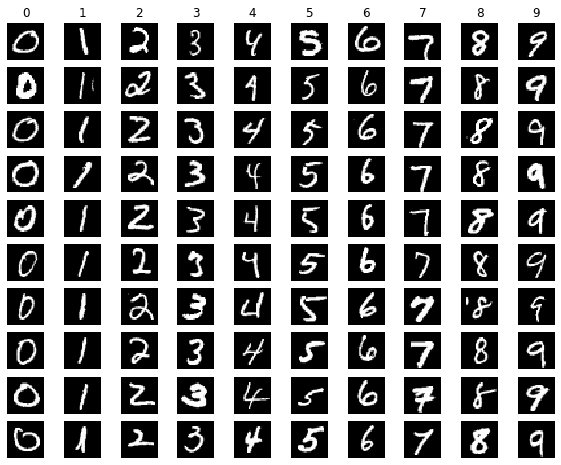

In [7]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(dataset.target == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(data[idx].astype('uint8').reshape(28, 28))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [8]:
# scale the input data to the range [0, 1] and perform a train/test split
(trainX, testX, trainY, testY) = train_test_split(data/255.0, dataset.target.astype("int"), test_size=0.25, random_state=42)

# convert the labels from integers to vectors
labelBinarizer = LabelBinarizer()
trainY = labelBinarizer.fit_transform(trainY)
testY = labelBinarizer.fit_transform(testY)

print('Training data shape: ', trainX.shape, trainX.dtype)
print('Training labels shape: ', trainY.shape, trainY.dtype)
print('Test data shape: ', testX.shape, testX.dtype)
print('Test labels shape: ', testY.shape, testY.dtype)

Training data shape:  (52500, 28, 28, 1) float64
Training labels shape:  (52500, 10) int64
Test data shape:  (17500, 28, 28, 1) float64
Test labels shape:  (17500, 10) int64


In [11]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=0.01)
model = LeNet5.build()
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=128, epochs=20, verbose=1)

[INFO] compiling model...
[INFO] training network...


ValueError: Error when checking input: expected conv2d_1_input to have shape (32, 32, 1) but got array with shape (28, 28, 1)

In [10]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=128)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=[str(x) for x in labelBinarizer.classes_]))

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1677
           1       0.99      0.99      0.99      1935
           2       0.98      0.99      0.99      1767
           3       0.98      0.98      0.98      1766
           4       0.99      0.99      0.99      1691
           5       0.99      0.98      0.98      1653
           6       0.99      0.99      0.99      1754
           7       0.98      0.99      0.99      1846
           8       0.98      0.97      0.97      1702
           9       0.97      0.98      0.98      1709

    accuracy                           0.98     17500
   macro avg       0.98      0.98      0.98     17500
weighted avg       0.98      0.98      0.98     17500



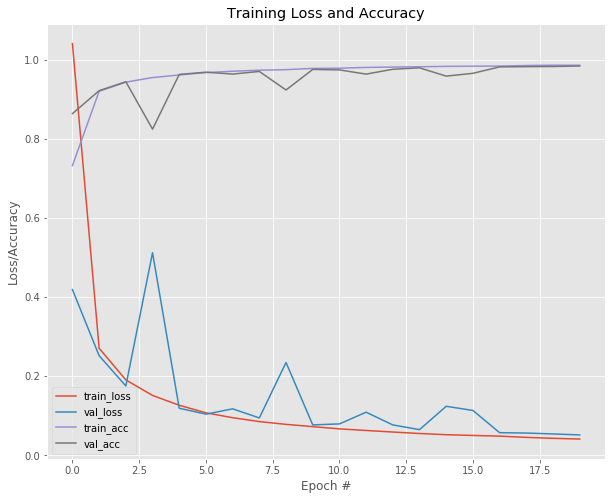

In [12]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 20), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()